# Exercise 5 (Hands-on): Single-cell RNA Sequencing and Deep Clustering

This notebook demonstrates the implementation of a deep learning-based clustering pipeline for single-cell RNA sequencing (scRNA-seq) data.
The workflow includes:
1. Data preprocessing for PBMC gene expression data.
2. Dimensionality reduction using an autoencoder.
3. Clustering cells with k-means.
Evaluation is done using Rand Index or Adjusted Rand Index.

## Install requirements
This section installs all necessary Python libraries and dependencies for running the notebook.

In [1]:
%pip install -U --quiet scikit-learn==1.3.2 torch==2.5.1 matplotlib==3.9.2 umap-learn==0.5.7 requests seaborn

Note: you may need to restart the kernel to use updated packages.


## Import necessary libraries
We import the libraries needed for data manipulation, model building, and evaluation.

In [2]:
# For file handling, data fetching, and extraction.
import os
from requests import get
import tarfile

# For numerical operations
import numpy as np
import pandas as pd
import seaborn as sns

# For building and training deep learning models
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# For clustering (KMeans), evaluation metrics (rand_score,
# adjusted_rand_score), and data splitting utilities
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# For timing and visualise final results
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import umap

# For extracting files
import tarfile
from pathlib import Path

## Configurable Constants
Define key constants for the notebook, such as file paths, model parameters, or dataset configurations.

In [12]:
# DATASET_URL: URL to download the compressed gene expression dataset.
DATASET_URL = "https://github.com/BackofenLab/ML_LS_resources/raw/refs/heads/master/exercise_5_scrna_deep_clustering_hands_on/data/gene_expression.tar.xz"

# DATASET_DIR_PATH: Path to the directory where the gene expression dataset will be stored.
BASE_DATA_DIR = Path("./data")
RAW_DATASET_DIR = Path(f"{BASE_DATA_DIR}/gene_expression.tar.xz")
DATA_DIR = Path(f"{BASE_DATA_DIR}/gene_expression")

# EPOCH_NUM: Number of epochs for training the model.
EPOCH_NUM = 20

# SEED: Random seed for reproducibility.
SEED = 42

## Setup GPU
Check for GPU availability and ensures that the computations are optimized for CUDA if a compatible GPU is available

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Extract the data
Extract the scRNA-seq dataset, which contains gene expression data
for 32,738 genes from 2700 cells of peripheral blood mononuclear cells (PBMCs), filtered to remove cells whose number of expressed genes is less than 200 to get a total of 2159 cells.

In [5]:
# Extract the gene expression dataset if not already extracted.
with tarfile.open(RAW_DATASET_DIR, mode="r:xz") as tar:
    tar.extractall(path=BASE_DATA_DIR)            

## Data Preprocessing
Load, preprocess, and prepare the scRNA-seq dataset for model training and evaluation.

In [8]:
# TODO: Load and check the shape of the raw gene expression data.
raw_gene_expression = np.load(f"{DATA_DIR}/matrix.npy")
raw_gene_expression.shape

(2159, 32738)

In [9]:
# Define a custom Dataset class for loading and preprocessing the gene expression data.
class RNADataset(Dataset):
    def __init__(self, dataset_path, label_path):
        # Load the dataset and corresponding labels.
        self.x_values, self.y_values = self.get_dataset(dataset_path, label_path)

        # TODO: Set the input shape and number of distinct labels for further use.
        self.input_shape = np.shape(self.x_values)[1]
        self.distinct_labels = len(np.unique(self.y_values))

    def get_dataset(self, dataset_path, label_path):
        # TODO: Load gene expression matrix from the dataset path using numpy.
        dataset = np.load(dataset_path)
        num_genes = np.shape(dataset)[1]

        # TODO: Load labels from the label file.
        label_file = open(label_path)
        labels = [l[:-1] for l in label_file.readlines()]  # Strip newline characters.

        # TODO: Remove genes with zero expression across all cells.
        gene_sum = np.sum(dataset, axis=0)
        non_empty_indices = [enum for enum, _ in enumerate(range(num_genes)) if gene_sum[enum] != 0]
        dataset = np.take(dataset, non_empty_indices, axis=1)

        return dataset, labels

    def return_y(self):
        # Return the labels.
        return self.y_values

    def return_x(self):
        # Return the dataset.
        return self.x_values

    def __len__(self):
        # Return the total number of samples.
        return len(self.y_values)

    def __getitem__(self, idx):
        # Return a specific sample and its corresponding label.
        return self.x_values[idx], self.y_values[idx]

In [10]:
# TODO: Instantiate the RNADataset class
dataset = RNADataset(f"{DATA_DIR}/matrix.npy", f"{DATA_DIR}/labels.txt")

print("Shape of the filtered dataset:", dataset.return_x().shape)

Shape of the filtered dataset: (2159, 16097)


In [15]:
# TODO: Initialize lists to store loss metrics
kfold_loss = []  # List to track k-fold cross-validation loss values
graph_sim_loss = []  # List to track graph similarity loss values (if used)

# TODO: Define a stratified split for cross-validation
# StratifiedShuffleSplit ensures proportional representation of labels in the splits
strat_split = StratifiedShuffleSplit(test_size=0.2, random_state=SEED)

# TODO: Split the dataset into training and testing sets
# Using train_test_split to split data indices into train and test sets with a fixed random state
X_train, X_test, y_train, y_test = train_test_split(
    range(len(dataset.return_x())),
    range(len(dataset.return_y())),
    test_size=0.2,
    random_state=SEED,
    stratify=dataset.return_y()
)

# TODO: Assign indices to training and test/validation splits
train_indices, test_val_ind = X_train, X_test

In [18]:
print(f"Unique cell types found: {np.unique(dataset.return_y())}")

Unique cell types found: ['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'Dendritic cells' 'NK cells']


## Define the Autoencoder
This section defines the autoencoder architecture, which will be used for dimensionality reduction of the scRNA-seq data.
The compressed representation learned by the autoencoder will serve as input for the clustering algorithm.

Use the following basic architecture: Encoder (BatchNorm -> Linear -> ReLU -> BatchNorm -> Linear -> ReLU -> BatchNorm) -> Decoder(Linear -> ReLU -> BatchNorm -> Linear)

In [22]:
# Define Hyperparameters
batch_size = 256
learning_rate = 1e-2
weight_decay = 0.00009

In [23]:
# TODO: Define an Autoencoder (AE) class (hint: use nn.Module as in the previous exercises)
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        # TODO: define the encoder: Maps input features to a lower-dimensional representation (latent space)
        self.encoder_hidden_layer = nn.Linear(in_features=input_shape, out_features=1280)
        self.batch_norm_in = nn.BatchNorm1d(input_shape)  # Normalize input features
        self.batch_norm1 = nn.BatchNorm1d(1280)
        self.encoder_output_layer = nn.Linear(in_features=1280, out_features=64)
        self.batch_norm2 = nn.BatchNorm1d(64)

        # TODO: define the decoder: Reconstructs the input features from the latent space
        self.decoder_hidden_layer = nn.Linear(in_features=64, out_features=1280)
        self.batch_norm3 = nn.BatchNorm1d(1280)
        self.decoder_output_layer = nn.Linear(in_features=1280, out_features=input_shape)

    def forward(self, features):
        # TODO: Encoder forward pass
        activation = self.batch_norm_in(features)
        activation = self.encoder_hidden_layer(activation)
        activation = torch.relu(activation)
        activation = self.batch_norm1(activation)

        code = self.encoder_output_layer(activation)  # Latent representation
        code = torch.relu(code)
        code = self.batch_norm2(code)

        # TODO: Decoder forward pass
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.batch_norm3(activation)

        reconstructed = self.decoder_output_layer(activation)  # Reconstructed output

        return reconstructed, code

In [24]:
# TODO: Initialize the Autoencoder
net = AE(input_shape=dataset.input_shape)  # Create the primary autoencoder instance
saved_net = AE(input_shape=dataset.input_shape)  # Create a secondary instance for saving/loading

# TODO: Define the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adam optimizer with L2 regularization
criterion = nn.L1Loss()  # L1 loss to measure the reconstruction error

In [25]:
# TODO: Split the test/validation indices into validation and test sets
split2 = int(np.floor(0.5 * len(test_val_ind)))  # Calculate the split point
val_indices, test_indices = test_val_ind[split2:], test_val_ind[:split2]  # Split indices

# TODO: Set a fixed random seed for reproducibility
g = torch.Generator()
g.manual_seed(SEED)

# TODO: Create samplers for different data splits
train_sampler = SubsetRandomSampler(train_indices)  # For training set
valid_sampler = SubsetRandomSampler(val_indices)    # For validation set
test_sampler = SubsetRandomSampler(test_indices)    # For test set

In [26]:
# TODO: Create DataLoader objects for efficient data batch processing (total, train, validation, test)
full_dataloader = DataLoader(dataset, batch_size=batch_size)  # DataLoader for the entire dataset
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, generator=g)  # Training DataLoader
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, generator=g)  # Validation DataLoader
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, generator=g)  # Test DataLoader

# TODO: Initialize a variable to track the best validation loss (used for early stopping or model evaluation)
best_validation = np.inf  # Set to a very high value initially

## Build, train, and evaluate the model
Define functions to build, train, and evaluate the autoencoder model.
The training process minimizes reconstruction loss to ensure the autoencoder effectively captures latent representations of the data.

In [28]:
def train_model(trainloader, net, criterion, optimizer, epoch):
    # TODO: Enable anomaly detection for debugging potential issues during backpropagation
    torch.autograd.set_detect_anomaly(True)

    # TODO: initialize running loss and reset network gradients
    running_loss = 0.0  # Initialize running loss
    net.zero_grad()  # Reset gradients for the network

    for i, data in enumerate(trainloader):  # Loop through the training data in batches
        input_data, target_data = data  # Extract inputs and targets
        loss = 0

        # TODO: Clear optimizer gradients, perform forward pass, compute loss, backpropagate, and update parameters
        optimizer.zero_grad()  # Clear optimizer gradients
        output, _ = net(input_data)  # Forward pass through the network

        loss = criterion(output, input_data)  # Compute reconstruction loss

        loss.backward()  # Backpropagate the loss
        running_loss += loss  

        optimizer.step()  # Update the model parameters

    # Return the trained model and average loss over all batches
    return net, running_loss / len(trainloader)

In [29]:
def eval_model(dataloader, net, criterion, epoch):
    # TODO: Define a function to evaluate the autoencoder model
    running_loss = 0  # Initialize running loss
    pearson_running_loss2 = 0  # Placeholder for additional loss metrics (if needed)

    # Lists to store input, output, and target data for analysis
    input_data_list = []
    output_data_list = []
    target_data_list = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data in dataloader:  # Iterate over batches in the DataLoader
            input_data, target_data = data  # Unpack inputs and targets
            loss = 0

            output, _ = net(input_data)  # Forward pass to get reconstructed output

            loss = criterion(output, input_data)  # Compute reconstruction loss

            running_loss += loss  # Accumulate the total loss

            # Store input, output, and target data for later analysis or visualization
            input_data_list.append(input_data)
            output_data_list.append(output.squeeze())
            target_data_list.append(input_data)

    # Return total loss and collected data
    return running_loss, output_data_list, input_data_list, target_data_list, pearson_running_loss2

In [30]:
# TODO: Train and validate the autoencoder model for the specified number of epochs
print("Training the model...")

times_per_epoch = []  # List to store time taken for each epoch
running_losses = []  # List to store running losses for each epoch
running_losses_val = []  # List to store validation losses for each epoch

for epoch in range(EPOCH_NUM):
    start_time = time.time()  # Record start time of the epoch

    # Train the model for one epoch and get the training loss
    net, running_loss = train_model(train_loader, net, criterion, optimizer, epoch)

    # Evaluate the model on the validation set and get the validation loss
    running_loss_val, output_data_list, input_data_list, target_data_list, pearson_running_loss2 = eval_model(validation_loader, net, criterion, epoch)

    # Save the model if the validation loss improves (after the initial training phase)
    if running_loss_val <= best_validation and epoch > int(EPOCH_NUM / 3):
        best_validation = running_loss_val
        saved_net.load_state_dict(net.state_dict())  # Save the model state

    epoch_time = time.time() - start_time  # Calculate time taken for this epoch

    running_losses.append(running_loss)  # Store training loss for this epoch
    running_losses_val.append(running_loss_val)  # Store validation loss for this epoch

    # Print the training and validation loss for the current epoch
    print(f"Epoch {epoch + 1}/{EPOCH_NUM} completed in {epoch_time:.4f} seconds - Training Loss: {running_loss:.4f}, Validation Loss: {running_loss_val:.4f}")

    times_per_epoch.append(time.time() - start_time)  # Calculate and store time taken for this epoch

print(f"Training completed in {sum(times_per_epoch):.4f} seconds.")
print(f"Best validation loss: {best_validation:.4f}")

Training the model...
Epoch 1/20 completed in 6.7268 seconds - Training Loss: 1.1065, Validation Loss: 0.7566
Epoch 2/20 completed in 6.2296 seconds - Training Loss: 0.5644, Validation Loss: 0.4280
Epoch 3/20 completed in 6.4531 seconds - Training Loss: 0.3904, Validation Loss: 0.3366
Epoch 4/20 completed in 6.1058 seconds - Training Loss: 0.3209, Validation Loss: 0.2912
Epoch 5/20 completed in 5.6703 seconds - Training Loss: 0.2820, Validation Loss: 0.2533
Epoch 6/20 completed in 5.6828 seconds - Training Loss: 0.2453, Validation Loss: 0.2233
Epoch 7/20 completed in 5.6810 seconds - Training Loss: 0.2213, Validation Loss: 0.2091
Epoch 8/20 completed in 5.9453 seconds - Training Loss: 0.2005, Validation Loss: 0.1940
Epoch 9/20 completed in 5.7490 seconds - Training Loss: 0.1897, Validation Loss: 0.1838
Epoch 10/20 completed in 5.7473 seconds - Training Loss: 0.1905, Validation Loss: 0.1880
Epoch 11/20 completed in 5.7105 seconds - Training Loss: 0.1982, Validation Loss: 0.1852
Epoch 12

In [31]:
# TODO: Evaluate the final trained model on the test set
# The `eval_model` function computes the test loss and collects output/input/target data
running_loss_test, output_data_list, input_data_list, target_data_list, pearson_running_loss2 = eval_model(test_loader, saved_net, criterion, epoch)

In [32]:
# TODO: Define a function to extract latent embeddings from the autoencoder
def get_embedding(dataloader, net):
    encoding_list = []  # Initialize a list to store embeddings

    with torch.no_grad():  # Disable gradient computation
        for data in dataloader:  # Iterate through the DataLoader
            input_data, target_data = data  # Extract input and target data
            output, encoding = net(input_data)  # Forward pass to get the encoded representation
            encoding_list.extend(encoding.tolist())  # Append the encodings to the list

    # Return the list of embeddings for further analysis or clustering
    return encoding_list

In [33]:
# TODO: Define a function to perform k-means clustering
def kmean_clustering(data, num_labels):
    # Perform k-means clustering on the input data
    # data: Input data for clustering (e.g., latent embeddings from the autoencoder)
    # num_labels: Number of clusters (e.g., distinct cell types)
    kmeans = KMeans(n_clusters=num_labels, n_init=10, random_state=SEED).fit(data)

    # Return the cluster labels assigned to each data point
    return kmeans.labels_

In [34]:
# TODO: Generate embeddings from the autoencoder's latent space
embedding = get_embedding(full_dataloader, saved_net)

# TODO: Perform k-means clustering on the latent embeddings
cluster_labels = kmean_clustering(embedding, dataset.distinct_labels)
encoder_x = LabelEncoder()
encoded_true_labels = encoder_x.fit_transform(dataset.return_y())

# TODO: Evaluate k-means clustering performance using Rand Index and Adjusted Rand Index
rand_score_eval = rand_score(encoded_true_labels, cluster_labels)  # Rand Index
adj_rand_score = adjusted_rand_score(encoded_true_labels, cluster_labels)  # Adjusted Rand Index
nmi = normalized_mutual_info_score(encoded_true_labels, cluster_labels)
ss = silhouette_score(embedding, cluster_labels)

## Analyze the results
Present and analyze the evaluation results, including:
- Test loss from the autoencoder.
- Clustering performance metrics (Rand Index and Adjusted Rand Index) for k-means and spectral clustering.

In [35]:
# TODO: Print evaluation results with improved formatting
print("#######################################################################")
print(f"Autoencoder Test Loss: {best_validation:.4f}")
print("#######################################################################")

print("Clustering Results (K-means):")
print(f"  Normalised Mutual Information: {nmi:.4f}")
print(f"  Rand Score: {rand_score_eval:.4f}")
print(f"  Adjusted Rand Index: {adj_rand_score:.4f}")
print(f"  Silhouette Score: {ss:.4f}")

print("#######################################################################")

#######################################################################
Autoencoder Test Loss: 0.1607
#######################################################################
Clustering Results (K-means):
  Normalised Mutual Information: 0.1849
  Rand Score: 0.5032
  Adjusted Rand Index: 0.1434
  Silhouette Score: 0.6594
#######################################################################


- NMI: Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).

- ARI: Adjusted Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical

- Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar

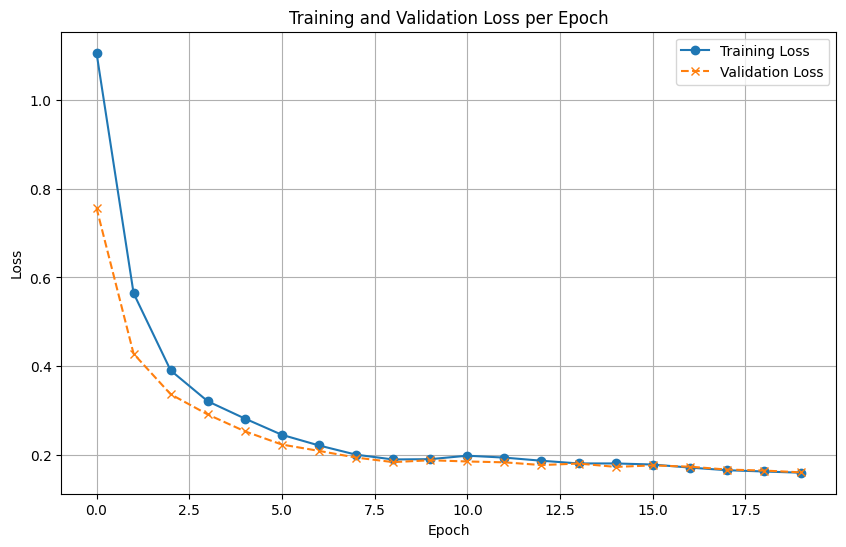

In [36]:
# TODO: Ensure running_losses and running_losses_val are detached tensors before plotting
training_losses = [loss.detach().numpy() for loss in running_losses]
validation_losses = [loss.detach().numpy() for loss in running_losses_val]

# TODO: Plot training vs. validation loss
plt.figure(figsize=(10, 6))
plt.plot(list(range(EPOCH_NUM)), training_losses, marker='o', label="Training Loss")
plt.plot(list(range(EPOCH_NUM)), validation_losses, marker='x', label="Validation Loss", linestyle="--")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Add legend to distinguish training and validation
plt.grid()  # Add grid lines for readability
plt.show()

#### Dimension reduction of preprocessed single-cell data using UMAP

In [37]:
# TODO: Perform UMAP on the original dimensions
original_umap_reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=50, min_dist=0.99, metric='correlation')
original_umap_embedding = original_umap_reducer.fit_transform(dataset.return_x())  # Apply UMAP on original data

/home/koeksalr/Downloads/machine_learning_in_life_science/exercise_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


      UMAP1     UMAP2        Celltypes
0  1.483383  2.770438      CD4 T cells
1  4.418974 -2.686733          B cells
2 -2.390461 -0.846100      CD4 T cells
3  6.729208  7.199531  CD14+ Monocytes
4 -3.428303  0.950191         NK cells


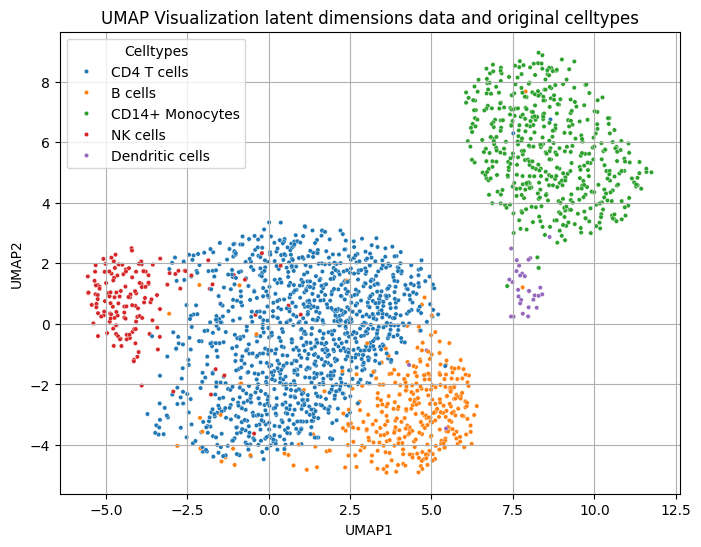

In [38]:
# distinct colors for labelling clusters
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# TODO: Visualize UMAP embeddings with original cell types
orginal_data = {"UMAP1": original_umap_embedding[:, 0], "UMAP2": original_umap_embedding[:, 1]}
df_original_sc = pd.DataFrame(orginal_data)

# TODO: Add cell type labels to the DataFrame for visualization
df_original_sc['Celltypes'] = dataset.return_y()
print(df_original_sc.head())

# TODO: Visualize UMAP embeddings with original cell types
plt.figure(figsize=(8, 6))
sns.scatterplot(x="UMAP1", y="UMAP2", hue="Celltypes", palette=color_list, data=df_original_sc, s=10)
plt.title("UMAP Visualization latent dimensions data and original celltypes")
plt.grid(True)
plt.show()

#### Dimension reduction of latent dimensions using UMAP

      UMAP1      UMAP2  KmeansClusters
0 -1.963563   7.046800               0
1  5.067684  10.121861               3
2  0.663140   9.274091               0
3  5.228238   2.486208               0
4 -1.919015  -3.546643               0


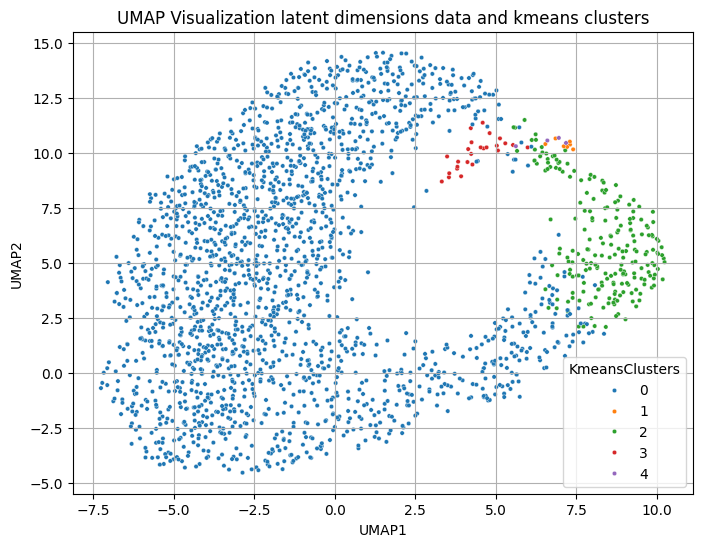

In [39]:
# TODO: Perform UMAP dimensionality reduction of latent dimensions
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1, n_neighbors=50, min_dist=0.99, metric='correlation')  # Reduce to 2 dimensions
umap_embedding = umap_reducer.fit_transform(embedding)  # Apply UMAP on embeddings

latent_data = {"UMAP1": umap_embedding[:, 0], "UMAP2": umap_embedding[:, 1]}
df_latent_sc = pd.DataFrame(latent_data)

df_latent_sc['KmeansClusters'] = cluster_labels
print(df_latent_sc.head())

# TODO: Visualize UMAP embeddings with k-means cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x="UMAP1", y="UMAP2", hue="KmeansClusters", palette=color_list, data=df_latent_sc, s=10)
plt.title("UMAP Visualization latent dimensions data and kmeans clusters")
plt.grid(True)
plt.show()